In [49]:
import matplotlib.pyplot as plt
import pandas as pd

rides = pd.read_csv('./data/rides.csv', parse_dates=['ride_start', 'ride_end'])
print(rides.head())
print(rides.info())

  ride_type ride_category     status  tip  surge  duration  distance  \
0   Comfort          TRIP  COMPLETED  1.0   0.00       956       3.9   
1     UberX          TRIP  COMPLETED  0.0   0.00       835       2.4   
2     UberX          TRIP  COMPLETED  3.0   0.00       642       1.6   
3     UberX          TRIP  COMPLETED  3.0   3.75       713       1.5   
4     UberX          TRIP  COMPLETED  3.0   0.00      1317       5.5   

                              pickup_address  \
0  N Ashland Ave, Chicago, IL 60614-1105, US   
1       N Lincoln Ave, Chicago, IL 60613, US   
2  N Clifton Ave, Chicago, IL 60657-2224, US   
3  W Belmont Ave, Chicago, IL 60657-4511, US   
4   N Whipple St, Chicago, IL 60647-3821, US   

                               dropoff_address  pickup_zip  dropoff_zip  \
0          W Madison St, Chicago, IL 60612, US     60614.0      60612.0   
1       N Southport Ave, Chicago, IL 60614, US     60613.0      60614.0   
2         N Lincoln Ave, Chicago, IL 60613, US     60

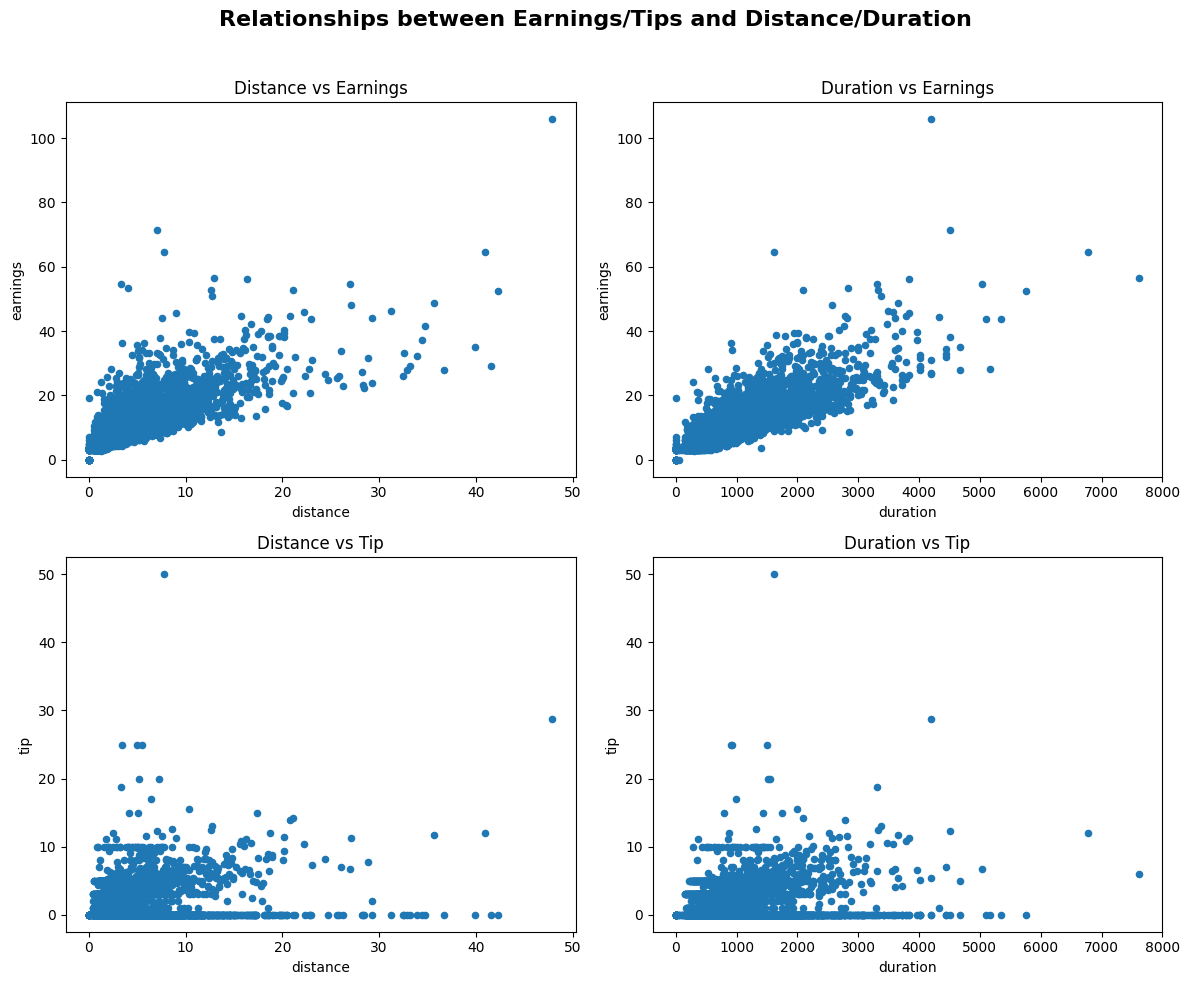

In [50]:
# Let's look at some scatter plots to reveal the relationship between earnings/tips and distance/time
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationships between Earnings/Tips and Distance/Duration', fontsize=16, fontweight="bold")

# Define the pairs of variables to plot
plot_pairs = [('distance', 'earnings'), ('duration', 'earnings'), ('distance', 'tip'), ('duration', 'tip')]

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (x, y) in zip(axes, plot_pairs):
    rides.plot.scatter(x=x, y=y, ax=ax)
    ax.set_title(f'{x.capitalize()} vs {y.capitalize()}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"visualizations/Earnings_Tips_vs_Distance_Duration.png", dpi=300)
plt.show()

In [51]:
rides['hour'] = rides['ride_start'].dt.hour
rides['day_of_week'] = rides['ride_start'].dt.day_of_week
rides['day_of_year'] = rides['ride_start'].dt.day_of_year

# How many actual days did I drive on?
unique_days = rides['ride_start'].dt.date.nunique()
print(f"I drove a total of {unique_days} days.")

I drove a total of 363 days.


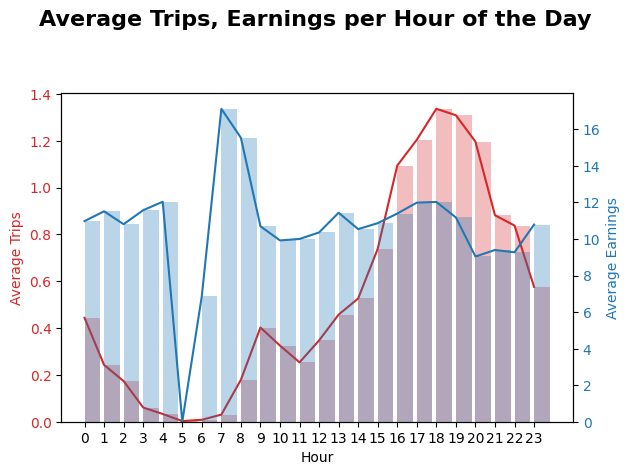

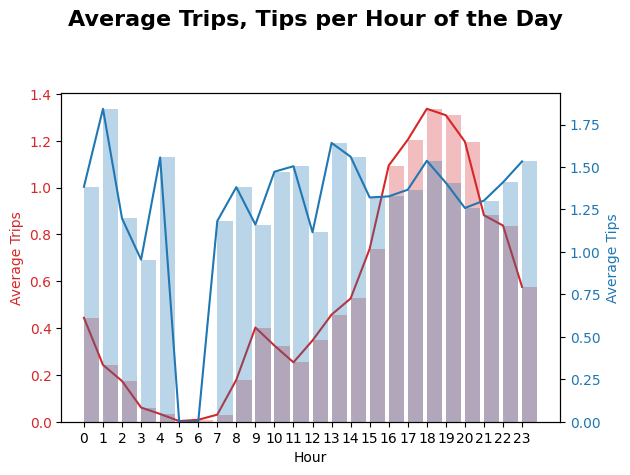

In [52]:
avg_earnings_per_hour = rides.groupby('hour')['earnings'].mean().to_frame()
avg_tips_per_hour = rides.groupby('hour')['tip'].mean().to_frame()
avg_trips_per_hour = rides.groupby('hour')['ride_start'].nunique().to_frame().rename(columns={'ride_start': 'trips'})
avg_trips_per_hour['trips'] = avg_trips_per_hour['trips'] / unique_days

# Make sure all hours are represented, not just the ones in the data. I know I wasn't up for driving very early shifts.
all_hours = pd.DataFrame({'hour': range(24)})
avg_earnings_per_hour = pd.merge(all_hours, avg_earnings_per_hour, left_index=True, right_index=True, how='left')
avg_earnings_per_hour.fillna({'earnings': 0}, inplace=True)
avg_tips_per_hour = pd.merge(all_hours, avg_tips_per_hour, left_index=True, right_index=True, how='left')
avg_tips_per_hour.fillna({'tips': 0}, inplace=True)
avg_trips_per_hour = pd.merge(all_hours, avg_trips_per_hour, left_index=True, right_index=True, how='left')
avg_trips_per_hour.fillna({'trips': 0}, inplace=True)

for (df, field, title, color) in [(avg_earnings_per_hour, 'earnings', 'Earnings', 'tab:blue'),
                                  (avg_tips_per_hour, 'tip', 'Tips', 'tab:blue')]:
    fig, ax1 = plt.subplots()

    fig.suptitle(f"Average Trips, {title} per Hour of the Day", fontsize=16, fontweight="bold")

    # Plot average trips per hour on the left y-axis using translucent bars and a line
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Average Trips', color='tab:red')
    ax1.bar(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red', alpha=0.3, align='edge')
    ax1.plot(avg_trips_per_hour['hour'], avg_trips_per_hour['trips'], color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for average earnings per hour with translucent bars and a line
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"Average {title}", color=color)
    ax2.bar(df['hour'], df[field], color=color, alpha=0.3, align='edge')
    ax2.plot(df['hour'], df[field], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set xticks for every hour (0 through 23)
    ax1.set_xticks(range(24))

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f"visualizations/AvgTrips_vs_{title}_per_hour.png", dpi=300)
    plt.show()